In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import jupyter_black

jupyter_black.load(lab=False)

# Intro to [timemachine](https://github.com/proteneer/timemachine)

A high-performance differentiable molecular dynamics, docking and optimization engine developed at Relay. Some notable design goals/features:

- Allows computation of derivatives of observables (eg. free energies) with respect to forcefield parameters using automatic differentiation
- Forcefields and potentials "first-class"; easy to work with outside of a simulation context, e.g. for post-processing tasks like free energy calculations

## Outline
1. [JAX crash course](#Part-1:-JAX-crash-course)
1. [Getting started with timemachine](#Part-2:-Getting-started-with-timemachine)
   1. [Defining and parameterizing a system](#Defining-and-parameterizing-a-system)
   1. [Running Langevin dynamics](#Running-Langevin-dynamics)
   1. [Setting up single-topology alchemical simulations](#Setting-up-single-topology-alchemical-simulations)
   1. [Vacuum free energy estimates](#Vacuum-free-energy-estimates)
   
---

## Part 1: JAX crash course

### Timemachine leverages Google's [JAX](https://github.com/google/jax) library for several key capabilities

- **Automatic differentiation**, e.g. differentiating BAR $\Delta G$ estimates w.r.t. forcefield parameters to enable fitting forcefield parameters to experimental free energies
- **Just-in-time compilation (JIT)** for efficient evaluation of potentials (can be 10–100x faster than plain numpy code)
- **Efficient batching** (running the same computation on a batch of data, maybe in parallel) using `vmap` and `pmap`

### `jax.numpy` is (mostly) a drop-in replacement for `numpy`

In [3]:
import numpy as np
import jax.numpy as jnp

In [4]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
jnp.arange(10)

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

*NOTE:* JAX can run computations on different backends (including CPU and CUDA GPU). In `timemachine` we currently only use the CPU backend

### JAX transforms Python functions

In [6]:
def norm(x):
    return jnp.sqrt(jnp.sum(x**2))

In [7]:
x = jnp.array([3.0, 4.0])

In [8]:
norm(x)

DeviceArray(5., dtype=float32)

In [9]:
from jax import grad, vmap, jit

#### `grad` transforms a function $f: \mathbb{R}^n \to \mathbb{R}$ into $\nabla f: \mathbb{R}^n \to \mathbb{R}^n$

NOTE: works for complex numbers too

In [10]:
dnorm = grad(norm)

In [11]:
dnorm(x)

DeviceArray([0.6, 0.8], dtype=float32)

#### `vmap` transforms a function to act on batches of input

In [12]:
xs = jnp.array([[3.0, 4.0], [5.0, 12.0], [8.0, 15.0]])

In [13]:
batched_norm = vmap(norm, in_axes=0)

In [14]:
batched_norm(xs)

DeviceArray([ 5., 13., 17.], dtype=float32)

#### `jit` transforms a function into a just-in-time-compiled equivalent

In [15]:
jit_norm = jit(norm)

In [16]:
%timeit norm(x).block_until_ready()

84.9 µs ± 2.16 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
%timeit jit_norm(x).block_until_ready()

2.65 µs ± 36.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


---
## Part 2: Getting started with [timemachine](https://github.com/proteneer/timemachine)

In [18]:
from rdkit.Chem.Draw import IPythonConsole

In [19]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = (300, 300)
IPythonConsole.ipython_useSVG = True

### Defining and parameterizing a system

In [20]:
from timemachine.datasets import fetch_freesolv

[09:29:07] Warning: molecule is tagged as 3D, but all Z coords are zero


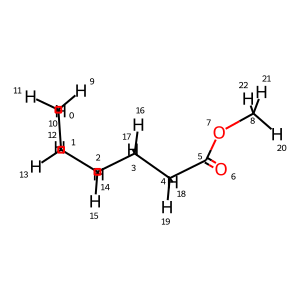

In [21]:
mol = fetch_freesolv()[0]
mol

In [22]:
from timemachine.constants import DEFAULT_FF
from timemachine.ff import Forcefield

Timemachine uses a variant of the Smirks Native Open Force Field (SMIRNOFF) specification

In [23]:
DEFAULT_FF

'smirnoff_1_1_0_ccc.py'

In [24]:
ff = Forcefield.load_from_file(DEFAULT_FF)

In [25]:
ff

Forcefield(hb_handle=<timemachine.ff.handlers.bonded.HarmonicBondHandler object at 0x7f13286d33a0>, ha_handle=<timemachine.ff.handlers.bonded.HarmonicAngleHandler object at 0x7f13286d3430>, pt_handle=<timemachine.ff.handlers.bonded.ProperTorsionHandler object at 0x7f13286d3880>, it_handle=<timemachine.ff.handlers.bonded.ImproperTorsionHandler object at 0x7f13286d30d0>, q_handle=<timemachine.ff.handlers.nonbonded.AM1CCCHandler object at 0x7f13286d3190>, lj_handle=<timemachine.ff.handlers.nonbonded.LennardJonesHandler object at 0x7f13286d3ca0>, protein_ff='amber99sbildn', water_ff='tip3p')

In [26]:
hb_params, hb_idxs = ff.hb_handle.parameterize(mol)
hb_params.shape, hb_idxs.shape

((22, 2), (22, 2))

In [27]:
from timemachine.fe.topology import BaseTopology

In [28]:
topo = BaseTopology(mol, ff)

In [29]:
# parameters, GPU potential = ...
hb_params, hb = topo.parameterize_harmonic_bond(ff.hb_handle.params)
ha_params, ha = topo.parameterize_harmonic_angle(ff.ha_handle.params)
pt_params, pt = topo.parameterize_proper_torsion(ff.pt_handle.params)
it_params, it = topo.parameterize_improper_torsion(ff.it_handle.params)
nb_params, nb = topo.parameterize_nonbonded(ff.q_handle.params, ff.lj_handle.params)

*NOTE:* timemachine has 2 implementation flavors for each potential:
- JAX reference potentials in `timemachine.potentials`
  - Relatively simple implementation close to mathematical definition
  - Implemented in `numpy` and `jax`
  - Useful for ligand vacuum sampling (and as reference in tests)
- GPU kernels in `timemachine.lib.potentials`
  - Implemented in C++/CUDA
  - Require a CUDA device to execute
  - Fast; useful for full systems including solvent or complex

In [30]:
from timemachine.potentials.generic import (
    HarmonicBond,
    HarmonicAngle,
    PeriodicTorsion,
    Nonbonded,
)

In [31]:
box = 1000.0 * np.eye(3)
lam = 0.0

In [32]:
harmonic_bond = HarmonicBond.from_gpu(hb).to_reference()
harmonic_angle = HarmonicAngle.from_gpu(ha).to_reference()
proper_torsion = PeriodicTorsion.from_gpu(pt).to_reference()
improper_torsion = PeriodicTorsion.from_gpu(it).to_reference()
nonbonded = Nonbonded.from_gpu(nb).to_reference()

In [33]:
def potential(conf):
    return (
        harmonic_bond(conf, hb_params, box, lam)
        + harmonic_angle(conf, ha_params, box, lam)
        + proper_torsion(conf, pt_params, box, lam)
        + improper_torsion(conf, it_params, box, lam)
        + nonbonded(conf, nb_params, box, lam)
    )

In [34]:
from timemachine.fe.utils import get_romol_conf
from rdkit.Chem import AllChem

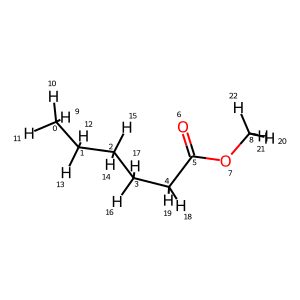

In [35]:
AllChem.EmbedMolecule(mol)
mol

In [36]:
init_conf = get_romol_conf(mol)

In [37]:
potential(init_conf)

DeviceArray(120.45408, dtype=float32)

### Running Langevin dynamics

In [38]:
from jax import grad, jit

In [39]:
grad_potential = grad(potential)

In [40]:
@jit
def force(conf):
    return -grad_potential(conf)

In [41]:
force(init_conf).shape

(23, 3)

In [42]:
jnp.linalg.norm(force(init_conf), axis=1).max()

DeviceArray(3481.3438, dtype=float32)

In [43]:
from timemachine.integrator import LangevinIntegrator
from timemachine.fe.utils import get_mol_masses

In [44]:
masses = get_mol_masses(mol)

In [45]:
temperature = 300.0

In [46]:
integ = LangevinIntegrator(force, masses, temperature, dt=1.5e-3, friction=1.0)

In [47]:
x0 = init_conf
v0 = jnp.zeros_like(init_conf)

In [48]:
xs, vs = integ.multiple_steps(
    x0, v0, n_steps=100_000  # 1e5 frames * 1.5e-3 ps/frame = 150 ps
)

In [49]:
xs.shape

(100001, 23, 3)

In [50]:
# Subtract center of mass from coordinates
com = (xs * masses[None, :, None] / masses[None, :, None]).mean(axis=1)
xs_imaged = xs - com[:, None, :]

In [51]:
import mdtraj
from simtk.openmm.app import PDBFile
from rdkit import Chem
import tempfile
from io import StringIO


def export_trajectory(xs, filename="trajectory.gro"):
    f = StringIO()
    f.write(Chem.MolToPDBBlock(mol))
    f.seek(0)
    pdb = PDBFile(f)
    traj = mdtraj.Trajectory(xs, mdtraj.Topology.from_openmm(pdb.topology))
    traj.save(filename)

In [52]:
export_trajectory(xs_imaged[::100])

### Setting up single-topology alchemical simulations

In [53]:
from importlib import resources

from timemachine.fe.single_topology import SingleTopology
from timemachine.fe.utils import get_mol_name

In [54]:
with resources.path("timemachine.testsystems.data", "ligands_40.sdf") as path:
    suppl = Chem.SDMolSupplier(str(path), removeHs=False)
    mols = {get_mol_name(mol): mol for mol in suppl}

In [55]:
mol_a = mols["206"]
mol_b = mols["57"]

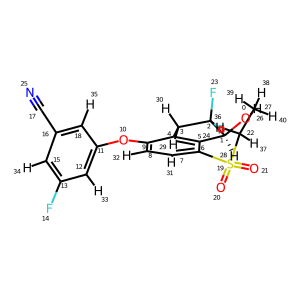

In [56]:
mol_a

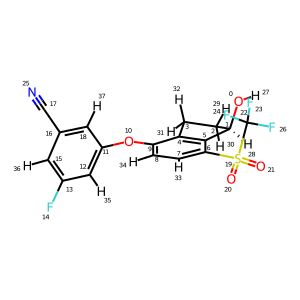

In [57]:
mol_b

In [58]:
from timemachine.fe.atom_mapping import get_core_by_mcs, mcs

In [59]:
mcs_max_distance = 2.0
mcs_result = mcs(mol_a, mol_b, threshold=mcs_max_distance)

In [60]:
query_mol = Chem.MolFromSmarts(mcs_result.smartsString)

In [61]:
core = get_core_by_mcs(mol_a, mol_b, query_mol, threshold=mcs_max_distance)

In [62]:
from timemachine.fe.utils import plot_atom_mapping_grid

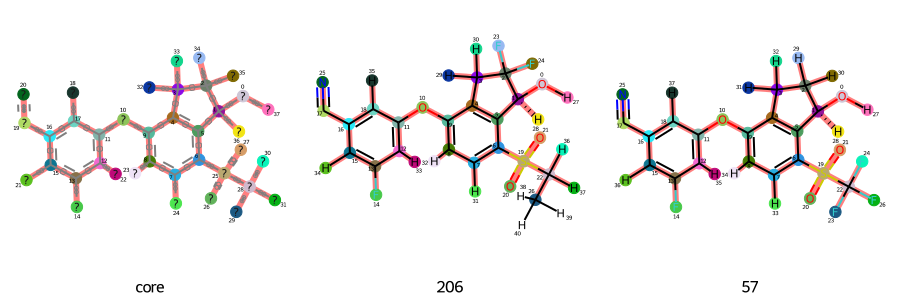

In [63]:
plot_atom_mapping_grid(mol_a, mol_b, mcs_result.smartsString, core)

In [64]:
st = SingleTopology(mol_a, mol_b, core, ff)

In [65]:
init_conf = st.combine_confs(get_romol_conf(mol_a), get_romol_conf(mol_b))
masses = np.array(st.combine_masses())

In [66]:
U_00 = st.setup_intermediate_state(0.0).get_U_fn()  # mol_a end state
U_01 = st.setup_intermediate_state(0.1).get_U_fn()  # alchemical intermediate at λ=0.1
U_10 = st.setup_intermediate_state(1.0).get_U_fn()  # mol_b end state

U_00(init_conf), U_01(init_conf), U_10(init_conf)

(DeviceArray(1963.1771, dtype=float32),
 DeviceArray(1829.2192, dtype=float32),
 DeviceArray(1546.6028, dtype=float32))

In [67]:
from timemachine.fe.system import minimize_scipy

In [68]:
lambdas = np.linspace(0, 1, 20)
U_fns = [st.setup_intermediate_state(lam).get_U_fn() for lam in lambdas]
U_fns = [jit(U_fn) for U_fn in U_fns]

In [69]:
import diskcache as dc
from tqdm import tqdm

In [70]:
cache = dc.Cache(".cache")

In [71]:
@cache.memoize()
def optimize_initial_conformations():
    return [minimize_scipy(U_fn, init_conf) for U_fn in tqdm(U_fns)]

In [72]:
init_confs = optimize_initial_conformations()

In [73]:
def sample(
    U_fn,
    x0,
    n_samples=100,
    steps_per_sample=1000,
):
    grad_U = grad(U_fn)

    @jit
    def force(x):
        return -grad_U(x)

    integ = LangevinIntegrator(force, masses, temperature, dt=1.5e-3, friction=1.0)

    xs = [x0]
    v = jnp.zeros_like(x0)

    for _ in tqdm(range(n_samples)):
        xs_, vs_ = integ.multiple_steps(xs[-1], v, steps_per_sample)
        xs.append(xs_[-1])
        v = vs_[-1]

    return xs

In [74]:
@cache.memoize()
def simulate():
    confs_kn = [sample(U_fn, x0) for U_fn, x0 in zip(U_fns, init_confs)]
    confs_kn = jnp.array(confs_kn)
    return confs_kn

In [75]:
confs_kn = simulate()

In [76]:
confs_kn.shape  # (state, sample, atom, xyz)

(20, 101, 41, 3)

### Vacuum free energy estimates

In [77]:
import matplotlib.pyplot as plt
import pymbar

from timemachine.constants import BOLTZ

In [78]:
kT = BOLTZ * temperature


def reduced_potential(lam, x):
    return st.setup_intermediate_state(lam).get_U_fn()(x) / kT


reduced_potential_n = vmap(reduced_potential, (None, 0))  # (sample,)
reduced_potential_kn = vmap(reduced_potential_n, (0, None))  # (states, sample)
reduced_potential_kln = vmap(
    reduced_potential_kn, (None, 0)
)  # (sampling state, evaluation state, sample)

# optional; ~10x speed boost
reduced_potential_n = jit(reduced_potential_n)
reduced_potential_kn = jit(reduced_potential_kn)
reduced_potential_kln = jit(reduced_potential_kln)

In [79]:
u_kn = reduced_potential_kn(lambdas, jnp.concatenate(confs_kn))
N_k = confs_kn.shape[1] * jnp.ones(confs_kn.shape[0])

In [80]:
mbar = pymbar.MBAR(u_kn, N_k)

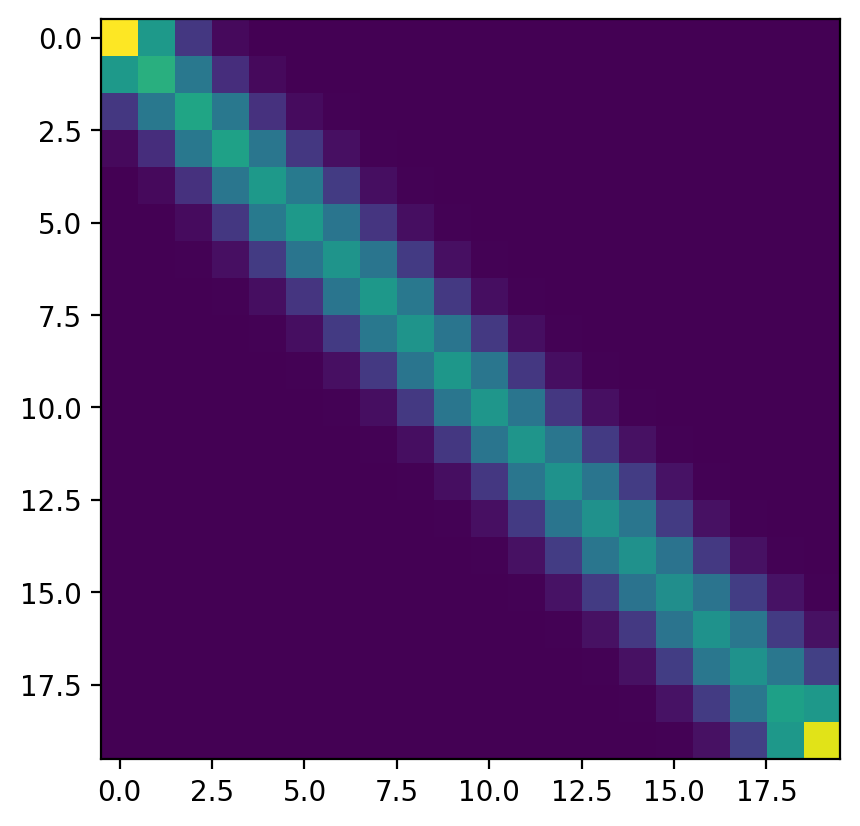

In [81]:
overlap = mbar.computeOverlap()
plt.imshow(overlap["matrix"]);

In [82]:
u_kln = reduced_potential_kln(lambdas, confs_kn)
u_kln.shape  # (sampling state, evaluation state, sample)

(20, 20, 101)

In [83]:
def pair_bar(i1, i2):
    x1 = confs_kn[i1]
    x2 = confs_kn[i2]

    w_F = u_kln[i1, i2] - u_kln[i1, i1]
    w_R = u_kln[i2, i1] - u_kln[i2, i2]

    df_bar, _ = pymbar.BAR(w_F, w_R)

    return df_bar, w_F, w_R


def plot_pair_bar(df_bar, w_F, w_R):
    def hist(w, **kwargs):
        plt.hist(w, density=True, alpha=0.5, **kwargs)

    hist(w_F, label="$w_F$")
    hist(-w_R, label="$-w_R$")
    plt.axvline(df_bar, color="gray", ls="--", label=r"$\Delta f_{\mathrm{BAR}}$")

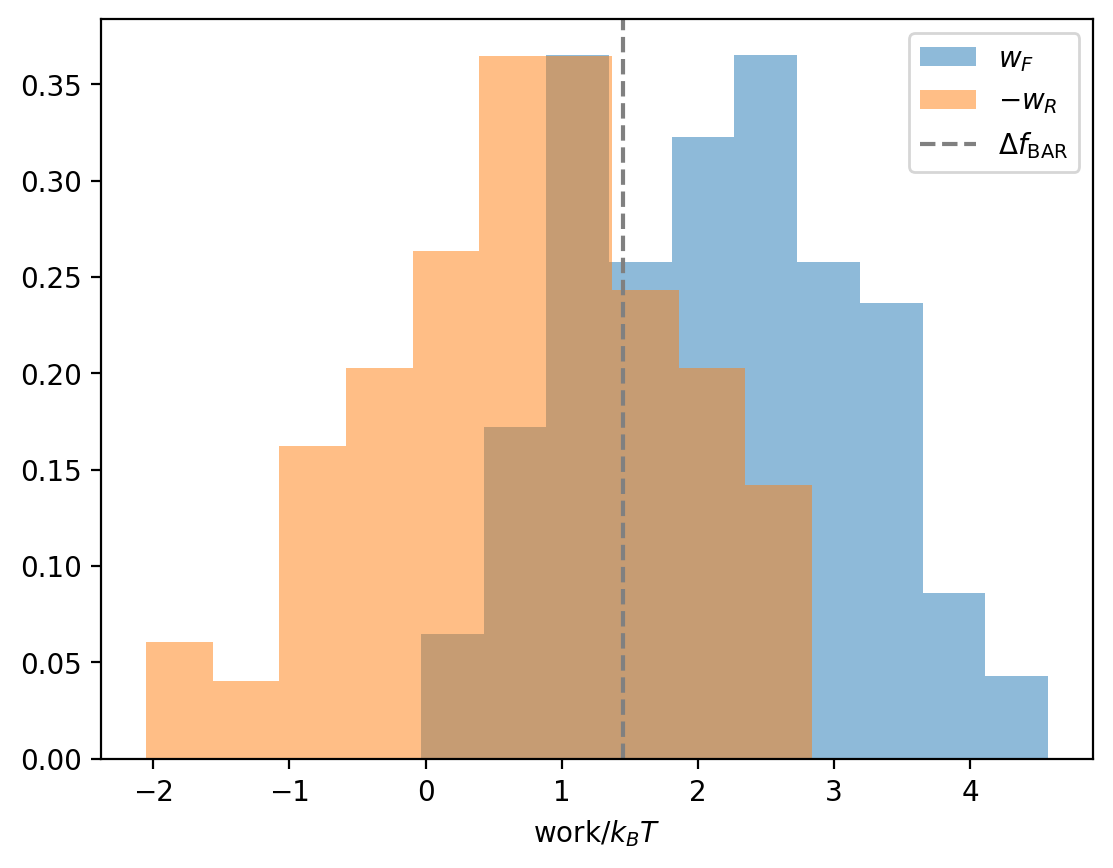

In [84]:
df_bar, w_F, w_R = pair_bar(0, 1)
plot_pair_bar(df_bar, w_F, w_R)
plt.xlabel("work$/k_B T$")
plt.legend();

In [85]:
mbar.f_k[-1]  # in units of k_B T

35.5063452808813

In [86]:
sum(pair_bar(i, i + 1)[0] for i in range(confs_kn.shape[0] - 1))

35.432841271571135